In [15]:
%pylab inline
import os, glob
import pandas

from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
folder = "data"
ext = ".asc"

In [17]:
files = glob.glob(os.path.join(folder, "*" +  ext))
lines = []
for f in files:
    t = pandas.read_csv(f,header=None, sep=" ")
    lines.append(t)

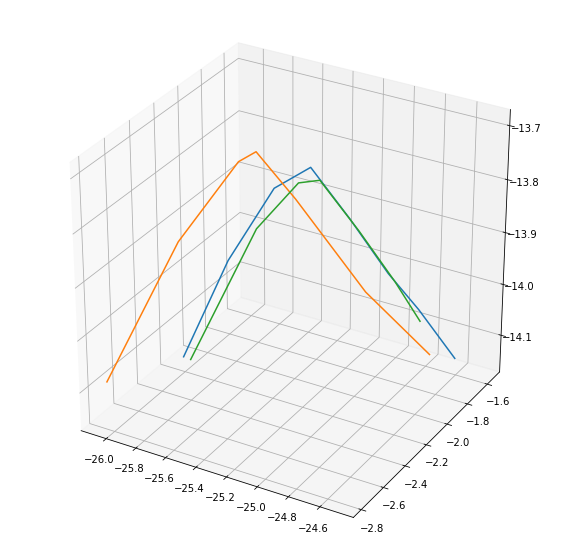

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
for line in lines:
    ax.plot(*np.array(line).T)

In [19]:
normals = []
for line in lines:
    M = np.cov(np.array(line).T)
    vals, evec = np.linalg.eig(M)
    mid = np.argmin(vals)
    normal = evec[:,mid]
    
    normals.append(normal)

In [20]:
%pylab qt
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
for line, normal in zip(lines, normals):
    ax.plot(*np.array(line).T)
    ax.quiver(*np.mean(line,axis=0), *normal, length=0.2)



Populating the interactive namespace from numpy and matplotlib


# Plot in stereoplot


In [21]:
normals

[array([ 0.43688054, -0.87267927,  0.21809694]),
 array([ 0.42785246, -0.87749902,  0.2166512 ]),
 array([ 0.41857736, -0.88099038,  0.22056508])]

In [22]:
import matplotlib.pyplot as plt
import mplstereonet

fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')


plunge, bearing = np.array(mplstereonet.vector2plunge_bearing(*np.array(normals).T))


ax.line(plunge, bearing, 'g^', markersize=6)
ax.grid(1)



# Converting to vtk

In [9]:
normals

[array([ 0.43688054, -0.87267927,  0.21809694]),
 array([ 0.42785246, -0.87749902,  0.2166512 ]),
 array([ 0.41857736, -0.88099038,  0.22056508])]

In [23]:
import vtk
from vtk.util.numpy_support import *

pdata = vtk.vtkPolyData()
allpts = np.row_stack(lines)

pts = vtk.vtkPoints()
pts.SetData(numpy_to_vtk(allpts))
pdata.SetPoints(pts)

In [24]:
w = vtk.vtkXMLPolyDataWriter()
w.SetFileName("lines.vtp")
w.SetInputData(pdata)
w.Update()

We want to add the connectivity information

In [25]:
cells = vtk.vtkCellArray()

current_id = 0

for line in lines:
    line=np.array(line)
    pline = vtk.vtkPolyLine()
    pline.GetPointIds().SetNumberOfIds(len(line))
    
    for i, point in enumerate(line):
        pline.GetPointIds().SetId( i, current_id)
        current_id += 1

    cells.InsertNextCell(pline)

pdata.SetLines(cells)

In [26]:
asarr = numpy_to_vtk(normals)
asarr.SetName("normals")
pdata.GetCellData().AddArray(asarr)

0

In [27]:
w = vtk.vtkXMLPolyDataWriter()
w.SetFileName("lines2.vtp")
w.SetInputData(pdata)
w.Update()